## 1. Cài đặt thư viện và cấu hình ban đầu

Phần code dưới đây thực hiện các thao tác sau:

- **Cài đặt các thư viện cần thiết:** `ultralytics` và `supervision`.  
- **Import** các module quan trọng như `os`, `numpy`, `supervision`, `ultralytics` và `IPython.display`.  
- **Xóa các output** hiện có trên màn hình và **kiểm tra cấu hình** của `ultralytics`.  
- **In ra phiên bản** của `supervision` và **xác định thư mục làm việc hiện tại (HOME)**.


In [2]:
# Cài đặt các thư viện cần thiết
!pip install ultralytics==8.3.19
!pip install supervision[assets]==0.24.0

# Import các thư viện cần thiết
import os
import numpy as np
import supervision as sv  # Thư viện hỗ trợ xử lý kết quả đầu ra từ YOLO model
import ultralytics          # Thư viện YOLO model
from ultralytics import YOLO
from IPython import display

# Xóa output hiện có trên màn hình để notebook sạch sẽ
display.clear_output()

# Kiểm tra cấu hình hệ thống và môi trường cho ultralytics
ultralytics.checks()

# In ra phiên bản supervision đã cài đặt
print("supervision.__version__:", sv.__version__)

# Lấy và in ra thư mục làm việc hiện tại (HOME)
HOME = os.getcwd()
print(HOME)

Ultralytics 8.3.19  Python-3.10.19 torch-2.9.0+cpu CPU (13th Gen Intel Core(TM) i7-13620H)
Setup complete  (16 CPUs, 15.7 GB RAM, 8.5/206.1 GB disk)
supervision.__version__: 0.24.0
e:\counting_vehicle


In [3]:
# Đường dẫn đến video đầu vào
SOURCE_VIDEO_PATH = "E:/counting_vehicle/vid_input.mp4"

## 2. Khởi tạo mô hình YOLOv8 và cấu hình nhận diện đối tượng

Đoạn code này thực hiện các bước sau:

- Tải mô hình YOLOv8 từ file `yolov8x.pt`.

- Lấy ra danh sách các tên lớp (class names) được lưu trong mô hình.

- Xác định các lớp đối tượng cần quan tâm (xe hơi, xe máy, xe buýt, xe tải) 
  và chuyển đổi tên lớp thành các ID tương ứng, lưu vào danh sách `SELECTED_CLASS_IDS`.


In [4]:
from ultralytics import YOLO

# Tải mô hình YOLOv8x bằng tệp trọng số được đào tạo trước
model = YOLO("yolov8x.pt")

# Truy xuất ID lớp ánh xạ từ điển thành tên lớp từ mô hình
CLASS_NAMES_DICT = model.model.names

# Xác định tên lớp được chọn để lọc phát hiện
SELECTED_CLASS_NAMES = ['car', 'motorcycle', 'bus', 'truck']

# Chuyển đổi tên lớp đã chọn thành ID lớp tương ứng của chúng
SELECTED_CLASS_IDS = [
    {value: key for key, value in CLASS_NAMES_DICT.items()}[class_name]
    for class_name in SELECTED_CLASS_NAMES
]

print("Class IDs for selected objects:", SELECTED_CLASS_IDS)


Class IDs for selected objects: [2, 3, 5, 7]


## 3. Dự đoán và chú thích một frame đơn lẻ

Tiếp theo, ta sẽ thực hiện việc tách frame từ video gốc, và thực hiện tracking trên 1 frame đó.

- Tạo một generator để lấy các frame từ video mẫu.

- Khởi tạo các đối tượng `BoxAnnotator` và `LabelAnnotator` dùng để vẽ bounding box và nhãn lên ảnh.

- Lấy frame đầu tiên từ video.

- Sử dụng mô hình YOLOv8 để dự đoán các đối tượng trên frame, chuyển kết quả thành định dạng `Detections` của thư viện `supervision`.

- Lọc các đối tượng theo các lớp đã chọn.

- Tạo nhãn cho mỗi đối tượng kèm theo thông tin độ tin cậy.

- Chú thích frame với bounding box và nhãn, sau đó hiển thị kết quả.


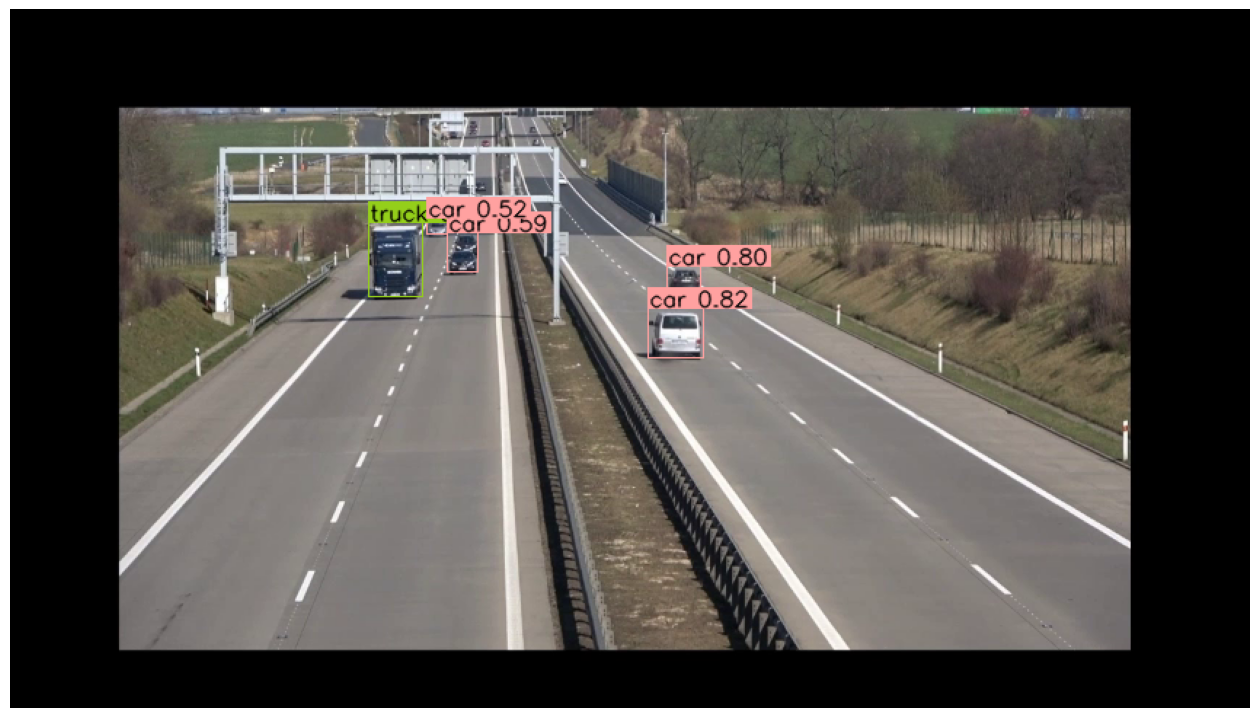

In [6]:
# ------------------ Khởi tạo bộ sinh khung hình video ------------------
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# Tạo các đối tượng annotator để vẽ hộp và nhãn trên hình ảnh
box_annotator = sv.BoxAnnotator(thickness=1)
label_annotator = sv.LabelAnnotator(
    text_thickness=1,
    text_scale=0.5,
    text_padding=1,
    text_color=sv.Color.BLACK
)

# ------------------ Xử lý một khung hình duy nhất ------------------
iterator = iter(generator)

# Lấy khung hình đầu tiên từ video
frame = next(iterator)

# Chạy mô hình YOLO trên khung hình để phát hiện đối tượng
results = model(frame, verbose=False)[0]

# Chuyển kết quả phát hiện của YOLO sang đối tượng Detections của thư viện Supervision
detections = sv.Detections.from_ultralytics(results)

# Lọc các kết quả phát hiện để chỉ giữ lại các lớp mong muốn (xe hơi, xe máy, xe buýt, xe tải)
detections = detections[np.isin(detections.class_id, SELECTED_CLASS_IDS)]

# Tạo nhãn cho các đối tượng được phát hiện (tên lớp + độ tin cậy)
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:.2f}"
    for confidence, class_id in zip(detections.confidence, detections.class_id)
]

# Tạo bản sao của khung hình để vẽ chú thích
annotated_frame = frame.copy()

# Vẽ các hộp bao quanh đối tượng được phát hiện
annotated_frame = box_annotator.annotate(
    scene=annotated_frame, detections=detections
)

# Vẽ các nhãn tên lớp và độ tin cậy lên đối tượng được phát hiện
annotated_frame = label_annotator.annotate(
    scene=annotated_frame, detections=detections, labels=labels
)

# Hiển thị khung hình đã được chú thích (có hộp và nhãn)
sv.plot_image(annotated_frame, (16, 16))


In [7]:
#lấy thông tin kích thước của video
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
print(f"Video Size: {video_info.width} x {video_info.height}")

Video Size: 852 x 480


## 4. Dự đoán và chú thích toàn bộ video sử dụng ByteTrack

Để đếm số lượng phương tiện đi qua một đường kẻ trong khung hình, ta sử dụng LineZone. Đầu tiên, ta định nghĩa điểm bắt đầu và kết thúc của LineZone:

- LINE_START tại tọa độ (0, 280)
- LINE_END tại tọa độ (852, 280)

Hai điểm này tạo thành một đường ngang ở vị trí y = 280 trong khung hình. khi một đối tượng di chuyển qua đường này theo một hướng nhất định, hệ thống sẽ ghi nhận và cập nhật bộ đếm số lượng phương tiện đã vượt qua. Cơ chế của LineZone hoạt động như sau:

- Theo dõi vị trí của đối tượng trong video
- Khi một đối tượng di chuyển qua đường giữa `LINE_START` và `LINE_END`, LineZone kiếm tả hướng di chuyển của đối tượng
- Nếu đối tượng di chuyển theo một hướng xác định (vd: từ trên xuống dưới hoặc ngược lại), hệ thống sẽ cập nhật bộ đếm phù hợp
- Kết quả cuối cùng sẽ được hiện thị trên video, cho biết số lượng phương tiện đã đi qua vùng đếm theo từng hướng

Các bước thực hiện:

1. Thiết lập đường dẫn cho video đầu ra
2. Lấy thông tin video mẫu
3. Tạo một thực thể ByteTrack để theo dõi khung hình
4. Tạo video generator và khởi tạo LineZone
5. Khởi tạo hàm callback để xử lý từng khung hình, phát hiện đối tượng và cập nhật chú thích
6. Sử dụng hàm `sv.process_video` để xử lý toàn bộ video với callback đã định nghĩa

In [ ]:
# Xác định các điểm đầu và điểm cuối của đường dùng để theo dõi vùng
LINE_START = sv.Point(0, 280)
LINE_END = sv.Point(852, 280)

# Xác định đường dẫn video xuất ra, nơi các kết quả sẽ được lưu
TARGET_VIDEO_PATH_V8_ByTr = "E:/counting_vehicle/output_v8_bytetrack.mp4"

# Lấy thông tin metadata từ video nguồn
sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# Khởi tạo tracker ByteTrack với các tham số tùy chỉnh
byte_tracker = sv.ByteTrack(
    track_activation_threshold=0.25,  # Ngưỡng độ tin cậy để kích hoạt một track mới
    lost_track_buffer=30,             # Số lượng frame giữ lại các track bị mất trước khi xóa
    minimum_matching_threshold=0.8,   # Ngưỡng IoU tối thiểu để ghép đối tượng
    frame_rate=30,                    # Tốc độ khung hình của video
    minimum_consecutive_frames=3      # Số lượng frame tối thiểu mà một đối tượng phải xuất hiện để được theo dõi
)

# Đặt lại tracker để bắt đầu theo dõi mới
byte_tracker.reset()

# Lấy lại thông tin metadata của video để xử lý
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# Tạo bộ sinh frame từ video
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# Định nghĩa một LineZone để theo dõi các đối tượng đi qua một đường xác định
line_zone = sv.LineZone(start=LINE_START, end=LINE_END)

# Khởi tạo các annotator khác nhau để hiển thị trực quan
box_annotator = sv.BoxAnnotator(thickness=1)  # Annotator vẽ hộp bao quanh đối tượng
label_annotator = sv.LabelAnnotator(text_thickness=1, text_scale=0.5,text_padding=1, text_color=sv.Color.BLACK) # Annotator hiển thị nhãn đối tượng
trace_annotator = sv.TraceAnnotator(thickness=4, trace_length=50) # Vẽ đường đi (trace) của đối tượng
line_zone_annotator = sv.LineZoneAnnotator(thickness=2, text_thickness=2, text_scale=1) # Annotator hiển thị đường LineZone

# Định nghĩa hàm callback để xử lý từng frame
def callback(frame: np.ndarray, index: int) -> np.ndarray:
    # Chạy mô hình YOLO trên frame hiện tại để phát hiện đối tượng
    results = model(frame, verbose=False)[0]

    # Chuyển các phát hiện của YOLO sang định dạng Detections của Supervision
    detections = sv.Detections.from_ultralytics(results)

    # Lọc các phát hiện chỉ bao gồm các lớp được chọn (cars, motorcycles, buses, trucks)
    detections = detections[np.isin(detections.class_id, SELECTED_CLASS_IDS)]

    # Cập nhật tracker với các phát hiện mới
    detections = byte_tracker.update_with_detections(detections)

    # Tạo nhãn chứa ID tracker, tên lớp, và độ tin cậy
    labels = [
        f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f}"
        for confidence, class_id, tracker_id in zip(detections.confidence, detections.class_id, detections.tracker_id)
    ]

    # Sao chép frame để gắn chú thích
    annotated_frame = frame.copy()

    # Gắn chú thích đường đi (trace) của đối tượng
    annotated_frame = trace_annotator.annotate(scene=annotated_frame, detections=detections)
    ## Gắn hộp bao quanh các đối tượng được phát hiện
    annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)
    # Gắn nhãn ID đối tượng và độ tin cậy
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

    # Kích hoạt LineZone khi đối tượng đi qua
    line_zone.trigger(detections)

    # Trả về frame đã gắn chú thích LineZone
    return line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)

# Xử lý video, áp dụng hàm callback cho từng frame
sv.process_video(
    source_path=SOURCE_VIDEO_PATH,  # Đường dẫn video đầu vào
    target_path=TARGET_VIDEO_PATH_V8_ByTr,  # Đường dẫn lưu video kết quả
    callback=callback               # Hàm xử lý từng frame
)

## 5. Deep SORT

### 5.1. Cài đặt thư viện và khởi tạo Deep SORT Tracker

Phần mã dưới đây thực hiện các thao tác sau:

- Cài đặt thư viện `deep_sort_realtime`.
- Import module `DeepSort` từ `deep_sort_realtime.deepsort_tracker`, cùng với các module cần thiết khác như `numpy` và `supervision`.
- Khởi tạo tracker của Deep SORT với các tham số tùy chỉnh: `max_age=30`, `n_init=3` và `max_cosine_distance`.

In [9]:
!pip install deep_sort_realtime
from deep_sort_realtime.deepsort_tracker import DeepSort

# Import các thư viện cần thiết
import numpy as np
import supervision as sv

# Đường dẫn video đầu ra (sau khi xử lý bằng DeepSORT)
TARGET_VIDEO_PATH_V8_DS = "E:/counting_vehicle/output_v8_deepsort.mp4"

# Khởi tạo bộ theo dõi DeepSORT với các tham số tùy chỉnh
deep_sort_tracker = DeepSort(
    max_age=30,               # Số lượng khung hình giữ lại một đối tượng bị mất trước khi xóa khỏi bộ nhớ
    n_init=3,                 # Số lần phát hiện tối thiểu trước khi xác nhận một đối tượng là hợp lệ
    max_cosine_distance=0.2   # Ngưỡng khoảng cách cosine tối đa để so khớp đặc trưng giữa các khung hình
)

### 5.2. Khởi tạo các annotators và đối tượng LineZone

Phần mã này khởi tạo các annotators để vẽ bounding box, nhãn và đường di chuyển (trace) lên các frame, cũng như đối tượng LineZone dùng để đánh dấu khu vực đếm đối tượng.


In [10]:
# Tạo một đối tượng BoxAnnotator để vẽ khung bao quanh các vật thể được phát hiện
box_annotator = sv.BoxAnnotator(thickness=1)

# Tạo một đối tượng LabelAnnotator để hiển thị nhãn văn bản trên các vật thể được phát hiện
label_annotator = sv.LabelAnnotator(text_thickness=1, text_scale=0.5, text_padding=1, text_color=sv.Color.BLACK)

# Tạo một đối tượng TraceAnnotator để hiển thị đường di chuyển (quỹ đạo) của các vật thể
trace_annotator = sv.TraceAnnotator(thickness=4, trace_length=50)

# Tạo một đối tượng LineZoneAnnotator để trực quan hóa và chú thích việc theo dõi vật thể dựa trên đường ranh giới (line tracking)
line_zone_annotator = sv.LineZoneAnnotator(thickness=2, text_thickness=2, text_scale=1)

# Định nghĩa một LineZone dùng để theo dõi các vật thể đi qua đường ranh giới xác định
line_zone = sv.LineZone(start=LINE_START, end=LINE_END)

### 5.3. Định nghĩa hàm callback để xử lý từng frame

Hàm `callback_ds` nhận đầu vào là một frame và chỉ số của frame. Các bước thực hiện trong hàm bao gồm:

- Thực hiện dự đoán với mô hình YOLOv8 trên frame và chuyển kết quả sang định dạng `Detections` của thư viện `supervision`.

- Lọc các đối tượng theo các lớp đã chọn.

- Chuyển đổi các detections sang định dạng phù hợp với Deep SORT: với mỗi đối tượng, trích xuất bounding box (chuyển từ định dạng `xyxy` thành `[left, top, width, height]`), độ tin cậy và tên lớp.

- Cập nhật tracker của Deep SORT bằng cách gọi hàm `update_tracks` với các detections đã chuyển đổi.

- Thu thập kết quả từ tracker: đối với mỗi track đã được xác nhận, trích xuất ID của tracker, bounding box (ở định dạng `ltrb`), độ tin cậy và chuyển đổi tên lớp thành class ID.

- Xây dựng đối tượng `Detections` từ kết quả theo dõi, hoặc tạo đối tượng rỗng nếu không có đối tượng nào được theo dõi.

- Sinh nhãn cho mỗi đối tượng theo dõi, với thông tin gồm tracker ID và tên lớp.

- Chú thích frame với các annotators: vẽ đường di chuyển (trace), bounding box và nhãn, đồng thời cập nhật vùng `LineZone`.


In [11]:
def callback_ds(frame: np.ndarray, index: int) -> np.ndarray:
    # Chạy mô hình YOLO trên khung hình đầu vào để phát hiện các đối tượng
    results = model(frame, verbose=False)[0]

    # Chuyển kết quả phát hiện của YOLO sang đối tượng Detections của thư viện Supervision
    detections = sv.Detections.from_ultralytics(results)

    # Lọc ra các đối tượng thuộc các lớp được chọn (ô tô, xe máy, xe buýt, xe tải)
    detections = detections[np.isin(detections.class_id, SELECTED_CLASS_IDS)]
    
    # Chuyển các kết quả phát hiện sang định dạng tương thích với DeepSORT (bbox, confidence, class_name)
    ds_detections = []
    for bbox, conf, class_id in zip(detections.xyxy, detections.confidence, detections.class_id):
        class_name = CLASS_NAMES_DICT.get(class_id, "Unknown")  # Lấy tên lớp từ ID lớp
        left, top, xmax, ymax = bbox  # Tách tọa độ khung bao (x1, y1, x2, y2)
        width, height = xmax - left, ymax - top  # Tính chiều rộng và chiều cao của khung
        ds_detections.append([[left, top, width, height], float(conf), class_name])

    # Cập nhật bộ theo dõi DeepSORT với các phát hiện mới
    tracks = deep_sort_tracker.update_tracks(ds_detections, frame=frame)

    # Khởi tạo các danh sách để lưu thông tin đối tượng đã được theo dõi
    tracked_bboxes = []
    tracked_confidences = []
    tracked_class_ids = []
    tracked_ids = []

    # Duyệt qua các đối tượng đang được theo dõi để lấy thông tin cần thiết
    for track in tracks:
        if not track.is_confirmed():  # Bỏ qua các đối tượng chưa được xác nhận
            continue

        track_id = track.track_id                # Lấy ID của đối tượng theo dõi
        bbox = track.to_tlbr()                   # Chuyển khung từ định dạng [x, y, w, h] sang [x1, y1, x2, y2]
        conf = getattr(track, 'det_conf', 1.0)   # Lấy độ tin cậy của phát hiện
        class_name = track.get_det_class() or "Unknown"  # Lấy tên lớp của đối tượng

        # Tìm class_id dựa trên tên lớp (đảo ngược ánh xạ CLASS_NAMES_DICT)
        class_id = {value: key for key, value in CLASS_NAMES_DICT.items()}.get(class_name, None)

        # Nếu không tìm thấy class_id thì gán giá trị mặc định là 0
        if class_id is None:
            class_id = 0

        # Lưu lại thông tin của đối tượng để hiển thị
        tracked_bboxes.append(bbox)
        tracked_confidences.append(conf)
        tracked_class_ids.append(class_id)
        tracked_ids.append(track_id)

    # Tạo đối tượng Detections của Supervision cho các đối tượng đã được theo dõi
    if len(tracked_bboxes) > 0:
        tracked_detections = sv.Detections(
            xyxy=np.array(tracked_bboxes, dtype=np.float32).reshape(-1, 4),
            confidence=np.array(tracked_confidences, dtype=np.float32),
            class_id=np.array(tracked_class_ids, dtype=np.int32),
            tracker_id=np.array(tracked_ids, dtype=np.int32),
        )
    else:
        # Xử lý trường hợp không phát hiện hoặc không theo dõi được đối tượng nào
        tracked_detections = sv.Detections(
            xyxy=np.zeros((0, 4), dtype=np.float32),
            confidence=np.array([], dtype=np.float32),
            class_id=np.array([], dtype=np.int32),
            tracker_id=np.array([], dtype=np.int32),
        )

    # Tạo nhãn (label) cho các đối tượng được theo dõi gồm ID và tên lớp
    labels = [
        f"#{tracker_id} {CLASS_NAMES_DICT.get(class_id, 'Unknown')}"
        for tracker_id, class_id in zip(tracked_ids, tracked_class_ids)
    ]

    # Sao chép khung hình gốc để vẽ các chú thích
    annotated_frame = frame.copy()

    # Vẽ đường di chuyển (trace) của các đối tượng được theo dõi
    annotated_frame = trace_annotator.annotate(scene=annotated_frame, detections=tracked_detections)

    # Vẽ khung bao quanh các đối tượng
    annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=tracked_detections)

    # Hiển thị nhãn chứa ID và tên lớp của từng đối tượng
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=tracked_detections, labels=labels)

    # Kích hoạt vùng đếm (LineZone) khi đối tượng băng qua đường kẻ
    line_zone.trigger(tracked_detections)

    # Chú thích đường đếm và hiển thị kết quả lên khung hình
    return line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)


# Xử lý toàn bộ video, áp dụng hàm callback_ds cho từng khung hình
sv.process_video(
    source_path=SOURCE_VIDEO_PATH,      # Đường dẫn video đầu vào
    target_path=TARGET_VIDEO_PATH_V8_DS,# Đường dẫn video đầu ra (đã gắn khung, nhãn, trace)
    callback=callback_ds                # Hàm xử lý từng khung hình
)

## Các bước dưới thực hiện cho YOLOv10 model tương tự khi sử dụng YOLOv8 model ở trên

### Khởi tạo mô hình YOLOv10 và cấu hình nhận diện đối tượng

In [15]:
from ultralytics import YOLO

# Tải mô hình YOLOv10x với trọng số đã được huấn luyện sẵn.
model_v10 = YOLO("yolov10x.pt")

# Lấy ra từ điển ánh xạ giữa ID của lớp và tên lớp từ mô hình.
CLASS_NAMES_DICT = model_v10.model.names

# Định nghĩa các tên lớp được chọn để lọc các đối tượng phát hiện
SELECTED_CLASS_NAMES = ['car', 'motorcycle', 'bus', 'truck']

# Chuyển các tên lớp được chọn thành các ID lớp tương ứng
SELECTED_CLASS_IDS = [
    {value: key for key, value in CLASS_NAMES_DICT.items()}[class_name]
    for class_name in SELECTED_CLASS_NAMES
]

print("Class IDs for selected objects:", SELECTED_CLASS_IDS)

Class IDs for selected objects: [2, 3, 5, 7]


### Dự đoán và chú thích một frame đơn lẻ

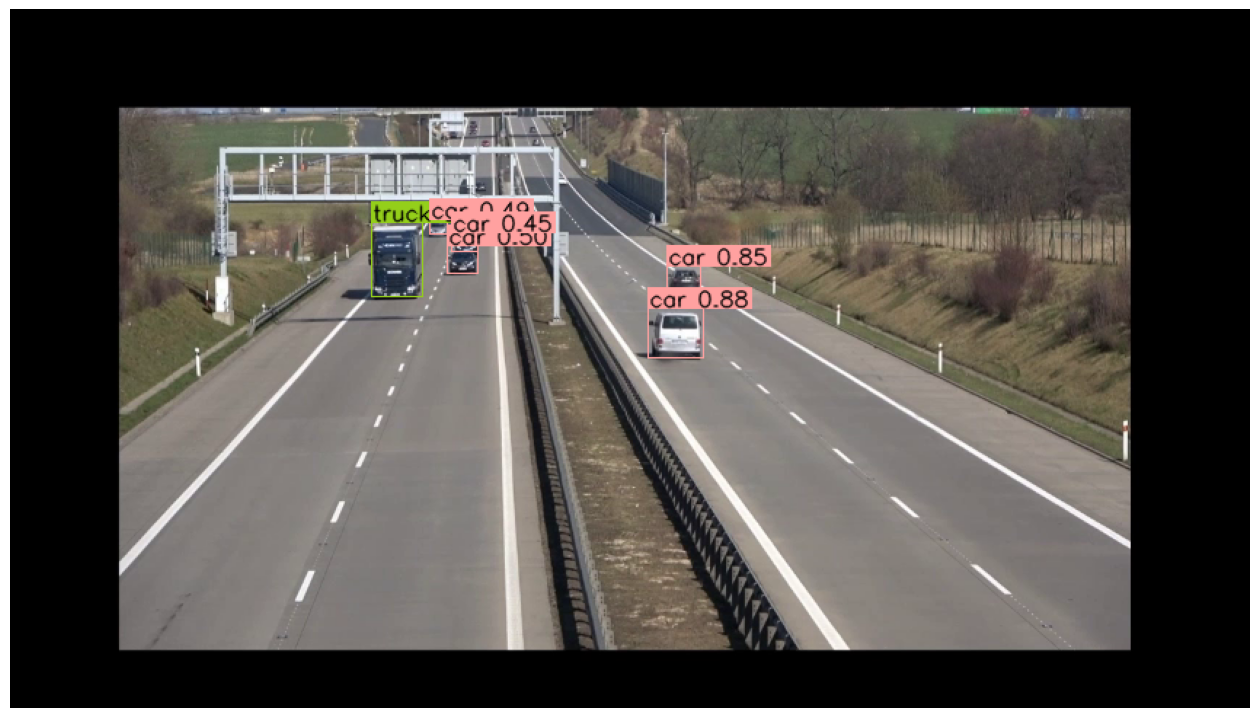

In [18]:


# ------------------ Khởi tạo bộ sinh khung hình video ------------------
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# Tạo các bộ chú thích (annotator) để vẽ khung và hiển thị nhãn
box_annotator = sv.BoxAnnotator(thickness=1)  # Dùng để vẽ khung bao quanh vật thể
label_annotator = sv.LabelAnnotator(          # Dùng để hiển thị nhãn văn bản
    text_thickness=1,
    text_scale=0.5,
    text_padding=1,
    text_color=sv.Color.BLACK
)

# ------------------ Xử lý một khung hình đơn ------------------
iterator = iter(generator)

# Lấy khung hình đầu tiên từ video
frame = next(iterator)

# Chạy mô hình YOLO trên khung hình để phát hiện các đối tượng
results = model_v10(frame, verbose=False)[0]

# Chuyển kết quả phát hiện của YOLO sang đối tượng Detections của thư viện Supervision
detections = sv.Detections.from_ultralytics(results)

# Lọc kết quả để chỉ giữ lại các lớp mong muốn (xe hơi, xe máy, xe buýt, xe tải)
detections = detections[np.isin(detections.class_id, SELECTED_CLASS_IDS)]

# Tạo nhãn cho các vật thể được phát hiện (tên lớp + độ tin cậy)
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:.2f}"
    for confidence, class_id in zip(detections.confidence, detections.class_id)
]

# Tạo một bản sao của khung hình để vẽ chú thích lên
annotated_frame = frame.copy()

# Vẽ khung bao quanh các vật thể được phát hiện
annotated_frame = box_annotator.annotate(
    scene=annotated_frame, detections=detections
)

# Hiển thị nhãn tên lớp và độ tin cậy trên từng vật thể
annotated_frame = label_annotator.annotate(
    scene=annotated_frame, detections=detections, labels=labels
)

# Hiển thị khung hình đã được chú thích (vẽ khung và nhãn)
sv.plot_image(annotated_frame, (16, 16))


### Dự đoán và chú thích toàn bộ video sử dụng ByteTrack

In [19]:

# Xác định điểm bắt đầu và kết thúc của vạch đếm phương tiện
LINE_START_2 = sv.Point(0, 280)
LINE_END_2 = sv.Point(852, 280)

# Đường dẫn lưu video kết quả (sau khi đã vẽ khung và đếm)
TARGET_VIDEO_PATH_V10 = "E:/counting_vehicle/output_v10_bytetrack.mp4"

# Lấy thông tin metadata (độ phân giải, fps, thời lượng, …) của video gốc
sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# KHỞI TẠO TRÌNH THEO DÕI BYTE-TRACK
byte_tracker = sv.ByteTrack(
    track_activation_threshold=0.25,  # Ngưỡng tin cậy tối thiểu để khởi tạo theo dõi mới
    lost_track_buffer=30,             # Số frame giữ lại khi vật thể bị mất trước khi xóa
    minimum_matching_threshold=0.8,   # Ngưỡng IoU tối thiểu để gán ID cho vật thể
    frame_rate=30,                    # Tốc độ khung hình (fps) của video
    minimum_consecutive_frames=3      # Số frame liên tiếp vật thể phải xuất hiện để được theo dõi
)

# Đặt lại tracker để bắt đầu lại quá trình đếm
byte_tracker.reset()



# CHUẨN BỊ DỮ LIỆU VIDEO VÀ VÙNG ĐẾM
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# Khởi tạo vùng (line zone) — dùng để phát hiện vật thể vượt qua vạch
line_zone = sv.LineZone(start=LINE_START_2, end=LINE_END_2)



# Vẽ khung bao quanh vật thể
box_annotator = sv.BoxAnnotator(thickness=1) 
# Hiển thị nhãn (tên lớp, độ tin cậy, ID)
label_annotator = sv.LabelAnnotator(          
    text_thickness=1,
    text_scale=0.5,
    text_padding=1,
    text_color=sv.Color.BLACK
)
# Vẽ vệt di chuyển (trace) của vật thể
trace_annotator = sv.TraceAnnotator(   
    thickness=4,
    trace_length=50
)
# Hiển thị vạch đếm và số lượng vật thể đã vượt qua
line_zone_annotator = sv.LineZoneAnnotator(
    thickness=2,
    text_thickness=2,
    text_scale=1
)

# 🔹 HÀM XỬ LÝ TỪNG FRAME (CALLBACK FUNCTION)
def callback(frame: np.ndarray, index: int) -> np.ndarray:
    #  Phát hiện vật thể bằng mô hình YOLOv10
    results = model_v10(frame, verbose=False)[0]

    #  Chuyển kết quả phát hiện sang định dạng Supervision
    detections = sv.Detections.from_ultralytics(results)

    #  Giữ lại các lớp mong muốn (xe hơi, xe máy, xe buýt, xe tải)
    detections = detections[np.isin(detections.class_id, SELECTED_CLASS_IDS)]

    #  Cập nhật theo dõi đối tượng bằng ByteTrack
    detections = byte_tracker.update_with_detections(detections)

    #  Tạo nhãn hiển thị: ID + tên lớp + độ tin cậy
    labels = [
        f"#{tracker_id} {model_v10.model.names[class_id]} {confidence:0.2f}"
        for confidence, class_id, tracker_id in zip(
            detections.confidence, detections.class_id, detections.tracker_id
        )
    ]

    #  Tạo bản sao khung hình để vẽ
    annotated_frame = frame.copy()

    #  Vẽ vệt di chuyển của các vật thể
    annotated_frame = trace_annotator.annotate(scene=annotated_frame, detections=detections)

    #  Vẽ khung bao quanh vật thể
    annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)

    #  Vẽ nhãn ID và độ tin cậy
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

    # Kiểm tra vật thể có cắt qua vạch đếm không
    line_zone.trigger(detections)

    #  Vẽ lại vạch đếm và hiển thị tổng số vật thể đã đi qua
    return line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)

# XỬ LÝ VIDEO TOÀN BỘ
sv.process_video(
    source_path=SOURCE_VIDEO_PATH,  # Đường dẫn video đầu vào
    target_path=TARGET_VIDEO_PATH_V10,  # Video đầu ra có khung + nhãn + đếm
    callback=callback               # Hàm xử lý cho từng khung hình
)


### Cài đặt thư viện và khởi tạo Deep SORT Tracker

In [20]:
# Cài đặt và import DeepSORT
!pip install deep_sort_realtime
from deep_sort_realtime.deepsort_tracker import DeepSort
import numpy as np
import supervision as sv

# Đường dẫn video sau khi xử lý bằng DeepSORT
TARGET_VIDEO_PATH_V10_DS = "E:/counting_vehicle/output_v10_deepsort.mp4"

# Khởi tạo bộ theo dõi DeepSORT
deep_sort_tracker = DeepSort(
    max_age=30,               # Giữ ID nếu vật thể mất tạm trong 30 frame
    n_init=3,                 # Cần phát hiện 3 lần liên tiếp để xác nhận vật thể
    max_cosine_distance=0.2   # Ngưỡng so khớp đặc trưng (càng nhỏ → chính xác hơn)
)

### Dự đoán và chú thích toàn bộ video sử dụng DeepSORT

In [21]:
# Tạo một instance của BoxAnnotator để vẽ khung bao quanh các vật thể được phát hiện
box_annotator = sv.BoxAnnotator(thickness=1)

# Tạo một instance của LabelAnnotator để hiển thị nhãn văn bản trên các vật thể
label_annotator = sv.LabelAnnotator(text_thickness=1, text_scale=0.5,text_padding=1, text_color=sv.Color.BLACK)

# Tạo một instance của TraceAnnotator để trực quan hóa vệt di chuyển của vật thể
trace_annotator = sv.TraceAnnotator(thickness=4, trace_length=50)

# Tạo một instance của LineZoneAnnotator để trực quan hóa và chú thích việc theo dõi dựa trên đường
line_zone_annotator = sv.LineZoneAnnotator(thickness=2, text_thickness=2, text_scale=1)

# Xác định một LineZone để theo dõi các vật thể vượt qua một đường cụ thể
line_zone = sv.LineZone(start=LINE_START_2, end=LINE_END_2)

def callback_ds(frame: np.ndarray, index: int) -> np.ndarray:
    # Chạy mô hình YOLO trên khung hình đầu vào để phát hiện vật thể
    results = model_v10(frame, verbose=False)[0]

    # Chuyển kết quả phát hiện YOLO thành một đối tượng Detections của Supervision
    detections = sv.Detections.from_ultralytics(results)

    # Lọc các phát hiện để giữ lại chỉ các lớp được chọn (xe hơi, xe máy, xe buýt, xe tải)
    detections = detections[np.isin(detections.class_id, SELECTED_CLASS_IDS)]
    
    # Chuyển các phát hiện sang định dạng tương thích với DeepSORT (bbox, độ tin cậy, tên lớp)
    ds_detections = []
    for bbox, conf, class_id in zip(detections.xyxy, detections.confidence, detections.class_id):
        class_name = CLASS_NAMES_DICT.get(class_id, "Unknown") # Lấy tên lớp từ ID
        left, top, xmax, ymax = bbox # Trích xuất tọa độ khung
        width, height = xmax - left, ymax - top # Tính chiều rộng và chiều cao
        ds_detections.append([[left, top, width, height], float(conf), class_name])

    # Cập nhật DeepSORT tracker với các phát hiện mới
    tracks = deep_sort_tracker.update_tracks(ds_detections, frame=frame)

    # Khởi tạo các danh sách để lưu thông tin vật thể được theo dõi
    tracked_bboxes = []
    tracked_confidences = []
    tracked_class_ids = []
    tracked_ids = []

    # Duyệt qua các vật thể được theo dõi và trích xuất thông tin cần thiết
    for track in tracks:
        if not track.is_confirmed(): # Bỏ qua các track chưa xác nhận
            continue

        track_id = track.track_id # Lấy ID track
        bbox = track.to_tlbr() # Chuyển đổi định dạng bbox cho tracking
        conf = getattr(track, 'det_conf', 1.0) # Lấy độ tin cậy phát hiện
        class_name = track.get_det_class() or "Unknown" # Lấy tên lớp

        # Lấy class_id từ class_name bằng cách đảo ngược dictionary CLASS_NAMES_DICT
        class_id = {value: key for key, value in CLASS_NAMES_DICT.items()}.get(class_name, None)

        # Gán ID lớp mặc định nếu không tìm thấy
        if class_id is None:
            class_id = 0

        # Lưu thông tin tracking để hiển thị
        tracked_bboxes.append(bbox)
        tracked_confidences.append(conf)
        tracked_class_ids.append(class_id)
        tracked_ids.append(track_id)

    # Tạo đối tượng Detections của Supervision cho các vật thể được theo dõi
    if len(tracked_bboxes) > 0:
        tracked_detections = sv.Detections(
            xyxy=np.array(tracked_bboxes, dtype=np.float32).reshape(-1, 4),
            confidence=np.array(tracked_confidences, dtype=np.float32),
            class_id=np.array(tracked_class_ids, dtype=np.int32),
            tracker_id=np.array(tracked_ids, dtype=np.int32),
        )
    else:
        # Xử lý trường hợp không phát hiện hoặc theo dõi được vật thể nào
        tracked_detections = sv.Detections(
            xyxy=np.zeros((0, 4), dtype=np.float32),
            confidence=np.array([], dtype=np.float32),
            class_id=np.array([], dtype=np.int32),
            tracker_id=np.array([], dtype=np.int32),
        )

    # Tạo nhãn cho các vật thể được theo dõi với ID và tên lớp
    labels = [
        f"#{tracker_id} {CLASS_NAMES_DICT.get(class_id, 'Unknown')}"
        for tracker_id, class_id in zip(tracked_ids, tracked_class_ids)
    ]

    # Sao chép khung hình để vẽ các chú thích
    annotated_frame = frame.copy()

    # Vẽ vệt di chuyển để trực quan hóa lịch sử di chuyển của vật thể
    annotated_frame = trace_annotator.annotate(scene=annotated_frame, detections=tracked_detections)

    # Vẽ khung quanh các vật thể được theo dõi
    annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=tracked_detections)

    # Hiển thị nhãn gồm ID track và tên lớp
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=tracked_detections, labels=labels)

    # Kích hoạt LineZone khi vật thể vượt qua đường
    line_zone.trigger(tracked_detections)

    # Vẽ LineZone và trả về khung hình cuối cùng
    return line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)

# Xử lý toàn bộ video sử dụng hàm callback trên
sv.process_video(
    source_path=SOURCE_VIDEO_PATH,
    target_path=TARGET_VIDEO_PATH_V10_DS,
    callback=callback_ds
)


## So sánh YOLOv8 và YOLOv10 với ByteTrack & DeepSORT

In [22]:
import cv2
import numpy as np

# === 1. Đường dẫn video ===
path_v8_bytetrack = "E:/counting_vehicle/output_v8_bytetrack.mp4"
path_v8_deepsort  = "E:/counting_vehicle/output_v8_deepsort.mp4"
path_v10_bytetrack = "E:/counting_vehicle/output_v10_bytetrack.mp4"
path_v10_deepsort  = "E:/counting_vehicle/output_v10_deepsort.mp4"

output_path = "E:/counting_vehicle/compare_yolov8_vs_yolov10.mp4"

# === 2. Hàm lấy thông tin video ===
def get_video_info(path):
    cap = cv2.VideoCapture(path)
    if not cap.isOpened():
        raise IOError(f"Không thể mở video: {path}")
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    cap.release()
    return {"width": width, "height": height, "fps": fps}

# Lấy thông tin video đầu tiên để làm chuẩn
info_ref = get_video_info(path_v8_bytetrack)
width, height, fps = info_ref["width"], info_ref["height"], info_ref["fps"]

# === 3. Mở video ===
caps = [
    cv2.VideoCapture(path_v8_bytetrack),
    cv2.VideoCapture(path_v8_deepsort),
    cv2.VideoCapture(path_v10_bytetrack),
    cv2.VideoCapture(path_v10_deepsort)
]

# === 4. Thiết lập VideoWriter cho video đầu ra ===
out_width = width * 2
out_height = height * 2
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
writer = cv2.VideoWriter(output_path, fourcc, fps, (out_width, out_height))

# === 5. Tiêu đề hiển thị trên từng ô ===
titles = [
    "YOLOv8 + ByteTrack",
    "YOLOv8 + DeepSORT",
    "YOLOv10 + ByteTrack",
    "YOLOv10 + DeepSORT"
]


# === 6. Vòng lặp đọc và ghép khung ===
frame_count = 0
while True:
    rets_frames = [cap.read() for cap in caps]
    if not all(ret for ret, _ in rets_frames):
        break 

    frames = []
    for (ret, frame), title in zip(rets_frames, titles):
        if not ret:
            frame = np.zeros((height, width, 3), dtype=np.uint8)
        else:
            frame = cv2.resize(frame, (width, height))
        cv2.putText(frame, title, (40, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 3, cv2.LINE_AA)
        frames.append(frame)

    # Ghép 2x2
    top_row = cv2.hconcat([frames[0], frames[1]])
    bottom_row = cv2.hconcat([frames[2], frames[3]])
    combined = cv2.vconcat([top_row, bottom_row])

    writer.write(combined)
    frame_count += 1

# === 7. Giải phóng tài nguyên ===
for cap in caps:
    cap.release()
writer.release()
cv2.destroyAllWindows()
